# Worksheet 4.1 SQL Injection Detection with Embeddings
In this lab we will use embeddings to identify malicious SQL queries.  SQL injection is a technique where attackers inject malicious code into SQL queries for execution.  You can read more here: https://en.wikipedia.org/wiki/SQL_injection.
You have already learned how to use lexical features to classify artifacts, but in this example, we will use a Random Forest Classifier, but instead of extracting features, we will use embeddings as a feature set.  You will then train a Random Forest Classifer to identify malicious queries.

We will perform this experiment on two datasets, one was generated with ChatGPT and the other is from a Kaggle competition: (https://www.kaggle.com/datasets/sajid576/sql-injection-dataset)  The two files are:
* `enriched_sql_injection_dataset_1000.csv`
* `Modified_SQL_Dataset.csv`

In [1]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from yellowbrick.classifier import ClassificationReport
from yellowbrick.classifier import ConfusionMatrix
DATA_PATH = '../data'

## Step 1:  Read in the Data
The first step is to read in the sample dataset into a Pandas dataframe.  The first dataset we will use is the sample data contained in the file `enriched_sql_injection_dataset_1000.csv`.

In [2]:
# Read in the data
raw_data = pd.read_csv(f"{DATA_PATH}/enriched_sql_injection_dataset_1000.csv")
raw_data.sample(5)

,query,label,length,num_keywords,has_comment,num_quotes,num_semicolons,has_union,has_exec,has_sleep,injection_type
988,SELECT * FROM employees WHERE department = 'su...,safe,53,3,False,2,1,False,False,False,none
98,SELECT * FROM accounts WHERE account_name = ''...,injection,123,7,True,4,1,False,False,False,other
24,"INSERT INTO logs (event, user_id) VALUES ('log...",safe,55,1,False,2,1,False,False,False,none
508,SELECT * FROM users WHERE username = 'admin'; ...,injection,66,4,True,2,2,False,False,False,data manipulation
578,SELECT * FROM sessions WHERE session_id = 'adm...,injection,79,4,True,4,2,False,False,True,time-based


## Step 2: Load the Model and Generate Embeddings
Now that we have the data in a Pandas Dataframe, the next step is to generate the embeddings. There are many models we could use for that, but for this exercise, we will use the model `paraphrase-MiniLM-L6-v2` (https://huggingface.co/sentence-transformers/paraphrase-MiniLM-L6-v2) which is a sentence transformer model that maps sentences and paragraphs to a 384 dimensional dense vector space.

This model provides a good balance between speed and effectiveness.

You can use the `SentenceTransformer` module to create the model. Next, use the encode function to create the embeddings.

In [3]:
# Load embedding model
model = SentenceTransformer('paraphrase-MiniLM-L6-v2')

In [4]:
# Generate embeddings
raw_data['embedding'] = raw_data['query'].apply(lambda x: model.encode(x).tolist())

# Take a look at a sample of the data to make sure
raw_data.sample(5)

,query,label,length,num_keywords,has_comment,num_quotes,num_semicolons,has_union,has_exec,has_sleep,injection_type,embedding
997,DELETE FROM temp_data WHERE created_at < NOW()...,safe,67,3,False,2,1,False,False,False,none,"[-0.1919776201248169, -0.08734158426523209, -0..."
556,SELECT * FROM employees WHERE department = 'ma...,safe,55,3,False,2,1,False,False,False,none,"[0.08352582901716232, -0.10470226407051086, -0..."
648,SELECT * FROM sessions WHERE session_id = 'adm...,injection,79,4,True,4,2,False,False,True,time-based,"[0.010189483873546124, -0.023661144077777863, ..."
644,DELETE FROM temp_data WHERE created_at < NOW()...,safe,67,3,False,2,1,False,False,False,none,"[-0.1919776201248169, -0.08734158426523209, -0..."
678,SELECT COUNT(*) FROM orders WHERE product_id =...,safe,50,3,False,0,1,False,False,False,none,"[-0.011718139052391052, 0.3227803111076355, -0..."


In [5]:
# Convert text labels to 0 and 1.
raw_data['final_label'] = raw_data['label'].map({"injection": 1, "safe": 0})
raw_data[['label', 'final_label']].sample(5)

,label,final_label
687,safe,0
532,injection,1
831,injection,1
651,injection,1
688,safe,0


Now that you generated the embeddings in a dataframe cell, you will need to extract them and convert them into a 2D list.  You can use the `tolist()` function to accomplish this.  You'll also need to extract the target vector.

Once you've done that, split the data into training and testing sets. Use 25% of the data for testing.  Next train a `RandomForestClassifier` using the training data and make a list of `predictions` using the testing features.

In [6]:
# Extract arrays from dataframe
features = np.array(raw_data['embedding'].tolist())
target = raw_data['final_label']

# Split into train/test
features_train, features_test, target_train, target_test = train_test_split(features, target, test_size=0.25)

# Train a model
clf = RandomForestClassifier()
clf.fit(features_train, target_train)
predictions = clf.predict(features_test)

### Step 3:  Evaluate the Model's Performance
Use Yellowbrick to create a confusion matrix and classification report to see how well the model performed.

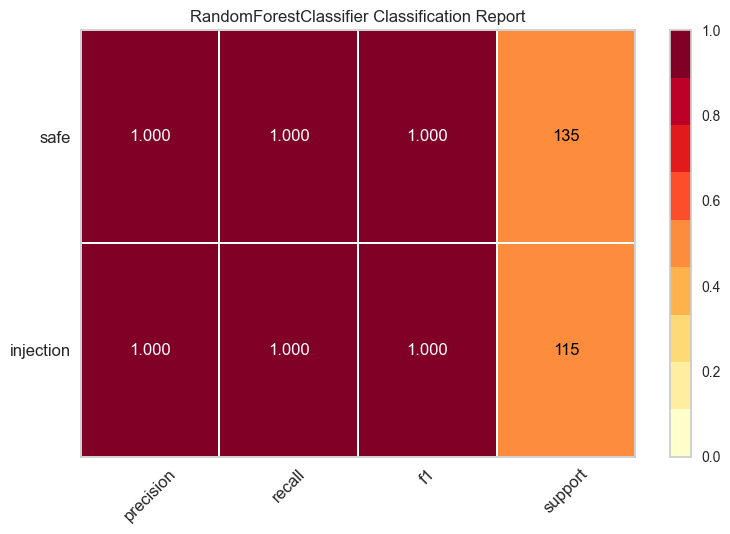

<Axes: title={'center': 'RandomForestClassifier Classification Report'}>

In [7]:
visualizer = ClassificationReport(clf, classes=["injection", "safe"], support=True)
visualizer.fit(features_train, target_train)
visualizer.score(features_test, target_test)
visualizer.show()

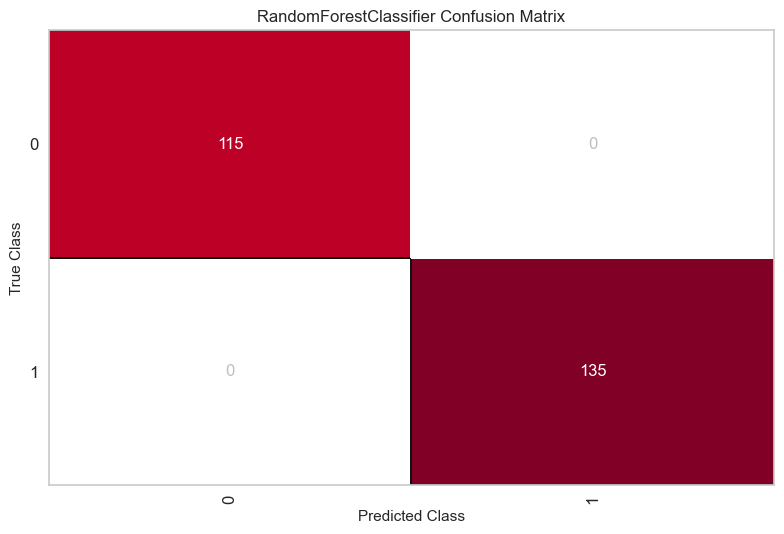

<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [8]:
cm = ConfusionMatrix(clf, classes=[0,1])
cm.fit(features_train, target_train)
cm.score(features_test, target_test)
cm.show()


As you can see, this model performs very well with the defaults, however this was with a synthetic dataset.  One approach you might consider is to use a SQL tokenizer to tokenize the SQL queries before generating embeddings.

```python
sql_tokenizer = Tokenizer()
sql_tokens = sql_tokenizer.tokenize(sql="SELECT * FROM users WHERE username = 'carol' AND password = '5845';")
token_types = [token.token_type.name for token in sql_tokens]
```
This converts the SQL query into the token string below:

```
['SELECT',
 'STAR',
 'FROM',
 'VAR',
 'WHERE',
 'VAR',
 'EQ',
 'STRING',
 'AND',
 'VAR',
 'EQ',
 'STRING',
 'SEMICOLON']
```
You could then generate embeddings from the token sequence.


## Step 4:  Repeat with Real Data
Next, we are going to train another model using a larger, non-generated dataset.  You can find the data in the file `Modified_SQL_Dataset.csv`.   How does this model perform?

In [10]:
raw_data2 = pd.read_csv(f"{DATA_PATH}/Modified_SQL_Dataset.csv")
raw_data2['embedding'] = raw_data2['Query'].apply(lambda x: model.encode(x).tolist())

features2 = np.array(raw_data2['embedding'].tolist())
target2 = raw_data2['Label']

# Split into train/test
features2_train, features2_test, target2_train, target2_test = train_test_split(features2, target2, test_size=0.25)

In [11]:
clf2 = RandomForestClassifier()
clf2.fit(features2_train, target2_train)
predictions2 = clf2.predict(features2_test)

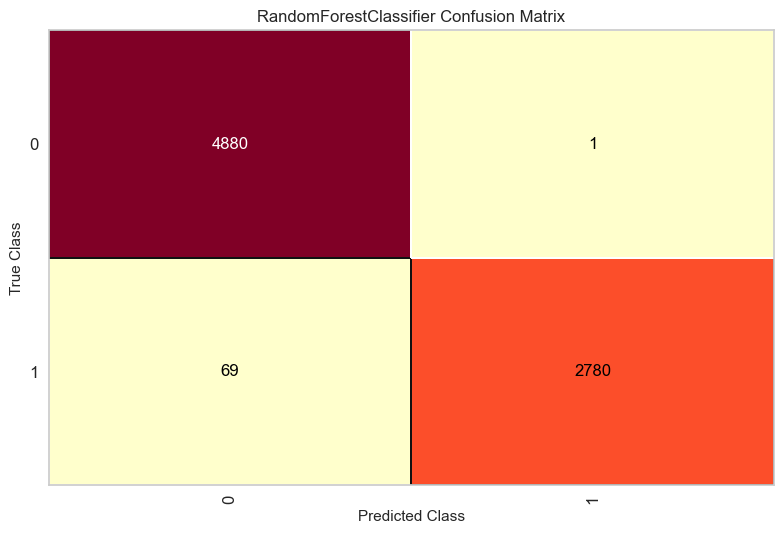

<Axes: title={'center': 'RandomForestClassifier Confusion Matrix'}, xlabel='Predicted Class', ylabel='True Class'>

In [12]:
cm = ConfusionMatrix(clf2, classes=[0,1])
cm.fit(features2_train, target2_train)
cm.score(features2_test, target2_test)
cm.show()

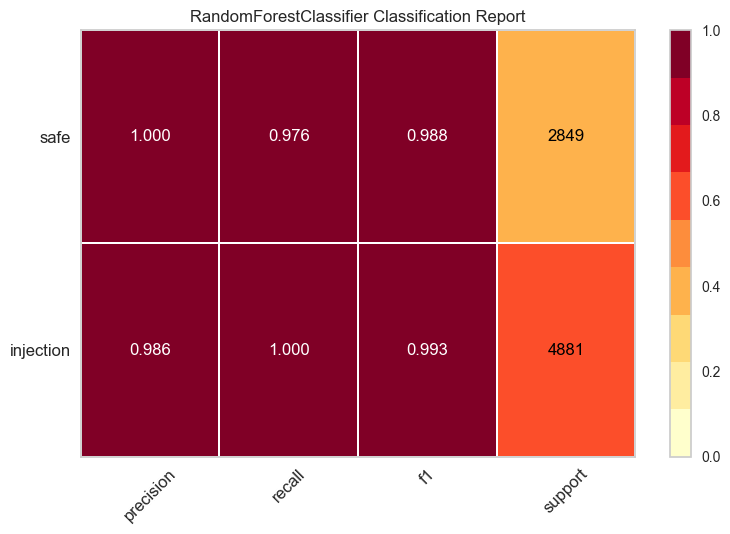

<Axes: title={'center': 'RandomForestClassifier Classification Report'}>

In [13]:
visualizer = ClassificationReport(clf2, classes=["injection", "safe"], support=True)
visualizer.fit(features2_train, target2_train)
visualizer.score(features2_test, target2_test)
visualizer.show()

## Try It Yourself
The code below is a wrapper function which allows a user to pass a SQL query to the model to see whether the model labels it as malicious or not.  Try it out and see how it does.

In [14]:
def is_possible_malicious_query(query: str, classifier) -> bool:
    df = pd.DataFrame(columns=['Query'])
    df['Query'] = [query]
    df['embedding'] = df['Query'].apply(lambda x: model.encode(query).tolist())
    embedding = np.array(df['embedding'].tolist())
    results = classifier.predict(embedding)
    return results[0]


In [15]:
print(is_possible_malicious_query("SELECT * FROM users WHERE username = 'carol' AND password = '5845' OR 1=1;", clf2))
print(is_possible_malicious_query("SELECT * FROM users WHERE username = 'carol' AND password = '5845'", clf2))

1
0


Next step... if you notice, the we created a feature matrix with 384 features, most of which are likely not predictive.